In [ ]:
# default_exp model.gru

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#! pip install datasets
#! pip install tokenizers -U
#! pip install tensorflow-gpu

In [ ]:
#HF datasets
from datasets import list_datasets, load_dataset, list_metrics, load_metric
from datasets import Dataset

In [ ]:
#HF preprocessing
from tokenizers import Tokenizer

In [ ]:
from datetime import datetime

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')) )
print("TF-Version ",  tf.version.VERSION )

Num GPUs Available:  0
TF-Version  2.3.0


In [ ]:
#To find out which devices your operations and tensors are assigned to
#tf.debugging.set_log_device_placement(True)

In [ ]:
#functional programming
import functools 

In [ ]:
#experimental
#import tensorflow.experimental.numpy as tnp

In [ ]:
from pathlib import Path

In [ ]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Deep Generative Coding with GRUs 
>
>@danaderp 11.17.20 This a GRU generative architecture for the CodeSearchNet dataset.
>

In [ ]:
path_data = Path('../dvc-icodegen') #dataset path
def params():
    return {
        'dummy_path' : path_data/'dummy/',
        'hyper': {
            'seq_length':100, #This Value depends on the EDA
            'batch_size':64,
            'buffer_size':10000,
            'rnn_units':1024,
            'epochs':10,
            'embed_dim':256
        },
        'checkpoint_dir':path_data/'models/gru/',
        'dataset':path_data/'searchnet/[codesearchnet-java-1597073966.81902].csv',
        'eda':path_data/'eda/',
        'tokenizer':path_data/'bpe/tokenizer-java.json'
    }

In [ ]:
params = params()

In [ ]:
#tst
logging.info(params['hyper']['seq_length'])
logging.info(params['dataset'])
logging.info(params['eda'])
logging.info(params['tokenizer'])

2020-11-25 17:54:46,169 : INFO : 100
2020-11-25 17:54:46,170 : INFO : ../dvc-icodegen/searchnet/[codesearchnet-java-1597073966.81902].csv
2020-11-25 17:54:46,171 : INFO : ../dvc-icodegen/eda
2020-11-25 17:54:46,172 : INFO : ../dvc-icodegen/bpe/tokenizer-java.json


## 1. Datasets Processing

In [ ]:
#Loading CodeSearchNet Dataset
java_df = pd.read_csv(params['dataset'], sep='~') #without bpe vectorization

In [ ]:
java_df.head(2)

,repo,path,url,code,code_tokens,docstring,docstring_tokens,language,partition,bpe32k,code_len,bpe32_len
0,apache/spark,sql/hive-thriftserver/src/main/java/org/apache...,https://github.com/apache/spark/blob/25ee0474f...,<@>Override<n> <public> OperationHandle getSc...,"['@', 'Override', 'public', 'OperationHandle',...",/* (non-Javadoc)\n@see org.apache.hive.service...,"['/', '*', '(', 'non', '-', 'Javadoc', ')']",java,train,"['▁', '@', 'Override', '▁public', '▁Operation'...",31.0,43.0
1,BlueBrain/bluima,modules/bluima_typesystem/src/main/java/de/jul...,https://github.com/BlueBrain/bluima/blob/793ea...,<public> <void> setTextObjects<(>FSArray v<)> ...,"['public', 'void', 'setTextObjects', '(', 'FSA...",setter for textObjects - sets the text objects...,"['setter', 'for', 'textObjects', '-', 'sets', ...",java,train,"['▁public', '▁void', '▁setText', 'Objects', '(...",64.0,92.0


### Vectorize the Tokens with BPE

In [ ]:
new_tokenizer = Tokenizer.from_file( str( params['tokenizer'] ) )

In [ ]:
# The unique subwords in the dataset
vocab = sorted(set( new_tokenizer.get_vocab().keys() ))
logging.info('{} unique characters'.format( len( vocab ) ) )

2020-11-25 17:54:54,317 : INFO : 10000 unique characters


In [ ]:
logging.info( new_tokenizer.encode(' <&&> <{>< Davidcito').tokens )
logging.info( new_tokenizer.encode(' <&&> <{>< Davidcito').ids )
logging.info( new_tokenizer.encode('  ').tokens )
logging.info( new_tokenizer.encode('  ').ids )
logging.info( new_tokenizer.encode('🤗').tokens )
logging.info( new_tokenizer.encode('🤗').ids )

2020-11-25 17:54:56,321 : INFO : ['Ġ', '<&&>', 'Ġ', '<{>', 'Ġ<', 'ĠD', 'av', 'id', 'c', 'it', 'o']
2020-11-25 17:54:56,322 : INFO : [186, 65, 186, 76, 190, 546, 1869, 287, 155, 258, 167]
2020-11-25 17:54:56,324 : INFO : ['ĠĠ']
2020-11-25 17:54:56,325 : INFO : [187]
2020-11-25 17:54:56,326 : INFO : ['Ġ']
2020-11-25 17:54:56,326 : INFO : [186]


In [ ]:
logging.info( new_tokenizer.encode( java_df.code.values[0] ).ids )

2020-11-25 14:56:03,101 : INFO : [83, 186, 601, 88, 187, 34, 3916, 2854, 4673, 1172, 349, 80, 5260, 2854, 1738, 2854, 100, 334, 242, 4739, 319, 100, 88, 300, 334, 2890, 319, 81, 186, 44, 726, 713, 5158, 186, 76, 88, 188, 35, 242, 474, 714, 102, 959, 1172, 349, 80, 1738, 2854, 100, 242, 4739, 319, 100, 2890, 319, 81, 82, 88, 187, 77]


In [ ]:
#This is the optimal way
output = new_tokenizer.encode_batch(
    [["Hello, y'all!", "How are you 😁 ?"], ["Hello to you too!", "I'm fine, thank you!"]]
)

Without BPE Vectorization

In [ ]:
java_df['bpe_ids'] = [ new_tokenizer.encode( str(m) ).ids for m in java_df.code.values] #Run this once

In [ ]:
timestamp = datetime.timestamp(datetime.now())
timestamp

1605759118.768157

In [ ]:
java_df.to_csv('../dvc-icodegen/searchnet/'+'[{}]-codesearchnet_java_bpe10k.csv'.format(timestamp), sep='~')

With BPE Vectorization

In [ ]:
java_df = pd.read_csv(path_data/'searchnet/[1605759118.768157]-codesearchnet_java_bpe10k.csv', sep='~', index_col=0) #with bpe vectorization

In [ ]:
java_df.head(1)

,repo,path,url,code,code_tokens,docstring,docstring_tokens,language,partition,bpe32k,code_len,bpe32_len,bpe_ids
0,apache/spark,sql/hive-thriftserver/src/main/java/org/apache...,https://github.com/apache/spark/blob/25ee0474f...,<@>Override<n> <public> OperationHandle getSc...,"['@', 'Override', 'public', 'OperationHandle',...",/* (non-Javadoc)\n@see org.apache.hive.service...,"['/', '*', '(', 'non', '-', 'Javadoc', ')']",java,train,"['▁', '@', 'Override', '▁public', '▁Operation'...",31.0,43.0,"[83, 186, 601, 88, 187, 34, 3916, 2854, 4673, ..."


In [ ]:
# Partitions
df_train = java_df[java_df['partition'] == 'train']
df_valid = java_df[java_df['partition'] == 'valid']
df_test = java_df[java_df['partition'] == 'test']

In [ ]:
logging.info("Train Partition Size "+ str(df_train.shape) )
logging.info("Valid Partition Size "+ str(df_valid.shape) )
logging.info("Test Partition Size "+ str(df_test.shape) )

2020-11-25 17:55:36,285 : INFO : Train Partition Size (384868, 13)
2020-11-25 17:55:36,286 : INFO : Valid Partition Size (14605, 13)
2020-11-25 17:55:36,287 : INFO : Test Partition Size (25011, 13)


In [ ]:
tokenizer_len = [len( eval(elem) ) for elem in df_train.bpe_ids.values] #Len of a method BECAREFUL when reading with BPE

In [ ]:
tokenizer_max_len = max( tokenizer_len ) #Max Len of a method
tokenizer_min_len = min( tokenizer_len ) #Min Len of a method

In [ ]:
logging.info("tokenizer_max_len "+ str( tokenizer_max_len ) )
logging.info("tokenizer_min_len "+ str( tokenizer_min_len ) )

2020-11-25 17:57:35,368 : INFO : tokenizer_max_len 85184
2020-11-25 17:57:35,369 : INFO : tokenizer_min_len 26


In [ ]:
df_train['tokenizer_len'] = tokenizer_len

/home/danaderp/.conda/envs/icodegen/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


*The prediction task*

Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?

In [ ]:
#Testing Decoder 
logging.info( df_train.code.values[0] ) 
logging.info( df_train.bpe_ids.values[0] ) 
logging.info( new_tokenizer.decode( eval( df_train.bpe_ids.values[0]) , skip_special_tokens=False ) ) #Enable special Tokens!
logging.info( new_tokenizer.decode( [0 ,1 ,0 ] , skip_special_tokens=False ) ) #Enable special Tokens!

2020-11-25 17:57:35,660 : INFO : <@>Override<n>  <public> OperationHandle getSchemas<(>SessionHandle sessionHandle, String catalogName,<n>      String schemaName<)> <throws> HiveSQLException <{><n>    <return> cliService.getSchemas<(>sessionHandle, catalogName, schemaName<)><;><n>  <}>
2020-11-25 17:57:35,661 : INFO : [83, 186, 601, 88, 187, 34, 3916, 2854, 4673, 1172, 349, 80, 5260, 2854, 1738, 2854, 100, 334, 242, 4739, 319, 100, 88, 300, 334, 2890, 319, 81, 186, 44, 726, 713, 5158, 186, 76, 88, 188, 35, 242, 474, 714, 102, 959, 1172, 349, 80, 1738, 2854, 100, 242, 4739, 319, 100, 2890, 319, 81, 82, 88, 187, 77]
2020-11-25 17:57:35,662 : INFO : <@> Override<n>  <public> OperationHandle getSchemas<(> SessionHandle sessionHandle, String catalogName,<n>      String schemaName<)> <throws> HiveSQLException <{><n>    <return> cliService.getSchemas<(> sessionHandle, catalogName, schemaName<)><;><n>  <}>
2020-11-25 17:57:35,663 : INFO : <abstract><assert><abstract>


## 2. EDA 
to determine the number of features in the tensor. Do not confuse with the number of batch. 

In [ ]:
df_train.describe().round(2)

,code_len,bpe32_len,tokenizer_len
count,384868.00,384868.00,384868.00
mean,113.72,147.15,234.01
std,194.01,313.90,493.64
min,20.00,20.00,26.00
25%,42.00,50.00,78.00
50%,67.00,81.00,128.00
75%,122.00,151.00,243.00
max,27192.00,52975.00,85184.00


In [ ]:
df_train.quantile(q=0.8)

code_len         144.0
bpe32_len        180.0
tokenizer_len    290.0
Name: 0.8, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc43606e10>,
      dtype=object)

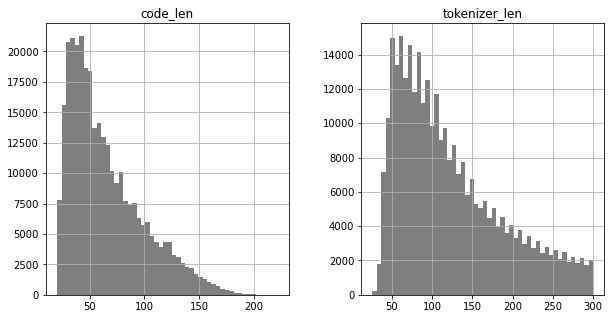

In [ ]:
# The maximum length sentence we want for a single input in characters
seq_length = 300 
#seq_length = params['hyper']['seq_length'] 
df_train[df_train['tokenizer_len']<=seq_length].hist(column=['tokenizer_len', 'code_len'],color='k',bins=50,figsize=[10,5],alpha=0.5)

### Tensorflow Datasets [Default]

In [ ]:
df_temp = df_train.head(300)

In [ ]:
df_temp.head(1)

,repo,path,url,code,code_tokens,docstring,docstring_tokens,language,partition,bpe32k,code_len,bpe32_len,bpe_ids,tokenizer_len
0,apache/spark,sql/hive-thriftserver/src/main/java/org/apache...,https://github.com/apache/spark/blob/25ee0474f...,<@>Override<n> <public> OperationHandle getSc...,"['@', 'Override', 'public', 'OperationHandle',...",/* (non-Javadoc)\n@see org.apache.hive.service...,"['/', '*', '(', 'non', '-', 'Javadoc', ')']",java,train,"['▁', '@', 'Override', '▁public', '▁Operation'...",31.0,43.0,"[83, 186, 601, 88, 187, 34, 3916, 2854, 4673, ...",60


*Masking* is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data.

*Padding* is a special form of masking where the masked steps are at the start or at the beginning of a sequence. Padding comes from the need to encode sequence data into contiguous batches: in order to make all sequences in a batch fit a given standard length, it is necessary to pad or truncate some sequences.

In [ ]:
#Resizing Methods
# It is recommended to use "post" padding when working with RNN layers
# (in order to be able to use the
# CuDNN implementation of the layers).
#For a padding reference check https://stackoverflow.com/questions/35751306/python-how-to-pad-numpy-array-with-zeros
def method_resize(np_non_rec, len_seq):
    """This function recieves a vector of encoded methods and resized according to a length sequence
    the length sequence es the number of columns or features
    The function takes a non-rectangular tensor and transforms it into a rectangular one
    """
    rows = int(np.ceil( np_non_rec.shape[0]  / len_seq )) #Minimum # of rows to complete/shape the sequence
    pad_diff = (rows * len_seq) - np_non_rec.shape[0] #1D required sequence minus the shape of the original tensor
    np_rec = np.pad(np_non_rec, [(0, pad_diff ),] , mode='constant', constant_values=0 ) #np padding with zeros
    np_rec = np.reshape( np_rec, (rows , len_seq) ) #Reshaping The Tensor
    return np_rec

In [ ]:
#The Following Function summarizes all the method transformation into sequences
def method2seq(raw_inputs, seq_length ):
    '''This Function generated the conceptual decomposition of a method into 
    a sequence or sequences given a max-len.
    # The method2seq method lets us easily convert these individual methods to sequences of the desired size.'''
    np_raw_inputs = [np.array( eval(m) ) for m in raw_inputs] #Extracting/Evaluating the tensors stored in pandas
    logging.info( 'Tensors were Extracted/Evaluated from pandas' ) 
    np_resized_inputs = [ method_resize( m, seq_length ) for m in np_raw_inputs ] #Resizing methods 
    logging.info( 'Methods Resized' )
    np_resized_inputs = functools.reduce(lambda a,b :np.concatenate((a,b), axis=0), np_resized_inputs ) #Merging Decomposed Sequences
    logging.info( 'Decomposed Sequences Merged' )
    return tf.data.Dataset.from_tensor_slices( np_resized_inputs )

#### Testing Tensorflow Datasets

In [ ]:
tf_sequences_train = method2seq( df_temp.bpe_ids.values, seq_length + 1 )

2020-11-25 18:04:03,590 : INFO : Tensors were Extracted/Evaluated from pandas
2020-11-25 18:04:03,612 : INFO : Methods Resized
2020-11-25 18:04:03,639 : INFO : Decomposed Sequences Merged


Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [ ]:
list(tf_sequences_train.as_numpy_iterator()) #TST

In [ ]:
tf_sequences_train = method2seq( df_train.bpe_ids.values, seq_length + 1 ) #The whole dataset

KeyboardInterrupt: 

In [ ]:
for i in tf_sequences_train.take(3):
    print( new_tokenizer.decode( i.numpy() , skip_special_tokens=False ) )

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
<@> Override<n>  <public> OperationHandle getSchemas<(> SessionHandle sessionHandle, String catalogName,<n>      String schemaName<)> <throws> HiveSQLException <{><n>    <return> cliService.getSchemas<(> sessionHandle, catalogName, schemaName<)><;><n>  <}><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstr

### HuggingFace Datasets [Not recommended]

In [ ]:
# Loading from In-Memory Data
hf_train_java = Dataset.from_pandas(df_temp)

In [ ]:
hf_train_java

Dataset(features: {'repo': Value(dtype='string', id=None), 'path': Value(dtype='string', id=None), 'url': Value(dtype='string', id=None), 'code': Value(dtype='string', id=None), 'code_tokens': Value(dtype='string', id=None), 'docstring': Value(dtype='string', id=None), 'docstring_tokens': Value(dtype='string', id=None), 'language': Value(dtype='string', id=None), 'partition': Value(dtype='string', id=None), 'bpe32k': Value(dtype='string', id=None), 'code_len': Value(dtype='float64', id=None), 'bpe32_len': Value(dtype='float64', id=None), 'bpe_ids': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}, num_rows: 3)

In [ ]:
hf_train_java['bpe_ids'][0]

'[83, 186, 601, 88, 187, 34, 3916, 2854, 4673, 1172, 349, 80, 5260, 2854, 1738, 2854, 100, 334, 242, 4739, 319, 100, 88, 300, 334, 2890, 319, 81, 186, 44, 726, 713, 5158, 186, 76, 88, 188, 35, 242, 474, 714, 102, 959, 1172, 349, 80, 1738, 2854, 100, 242, 4739, 319, 100, 2890, 319, 81, 82, 88, 187, 77]'

In [ ]:
hf_train_java.set_format(type='tensorflow', columns=['bpe_ids'])

In [ ]:
#A Dictionary of Features
train_features = {x: hf_train_java[x].to_tensor(default_value=0, shape=[ None, tokenizer_max_len ]) for x in ['bpe_ids']}

AttributeError: 'list' object has no attribute 'to_tensor'

In [ ]:
type(train_features['bpe_ids'])

tensorflow.python.framework.ops.EagerTensor

In [ ]:
# Create training examples / targets
tfdataset = tf.data.Dataset.from_tensor_slices((features, hf_train_java["bpe_ids"]))

## 3. Create training examples and targets

For each sequence, duplicate and shift it to form the input and target text by using the map method to apply a simple function to each batch:

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [ ]:
#dataset = sequences.map(split_input_target)
dataset = tf_sequences_train.map( split_input_target ) #TST <----- Deactivate when using the big dataset

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [ ]:
#Print the first example input and target values:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', new_tokenizer.decode( input_example.numpy() , skip_special_tokens=False ) )
    print('Target data:', new_tokenizer.decode( target_example.numpy() , skip_special_tokens=False ) )

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Input data:  <@> Override<n>  <public> OperationHandle getSchemas<(> SessionHandle sessionHandle, String catalogName,<n>      String schemaName<)> <throws> HiveSQLException <{><n>    <return> cliService.getSchemas<(> sessionHandle, catalogName, schemaName<)><;><n>  <}><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><ab

Each index of these vectors is processed as a one time step. For the input at time step 0, the model receives the index for "<@>" and tries to predict the index for "Override" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format( input_idx, new_tokenizer.decode( [input_idx], skip_special_tokens=False ) ) )
    print("  expected output: {} ({:s})".format( target_idx, new_tokenizer.decode( [target_idx], skip_special_tokens=False ) ) )

Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Step    0
  input: 83 (<@>)
  expected output: 186 ( )
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Step    1
  input: 186 ( )
  expected output: 601 (Override)
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Step    2
  input: 601 (Override)
  expected output: 88 (<n>)
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Step    3
  

### Creating training batches
We use numpy to decompose the methods into sequences and then tf.data to create the tensors. But before feeding this data into the model, we need to shuffle the data and pack it into batches (or managable portions of data).

In [ ]:
BATCH_SIZE = params['hyper']['batch_size'] # Batch size [Warning for testing]

In [ ]:
# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = params['hyper']['buffer_size']

In [ ]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


In [ ]:
dataset

<BatchDataset shapes: ((64, 300), (64, 300)), types: (tf.int64, tf.int64)>

## 4. Building The Model

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = params['hyper']['embed_dim']

# Number of RNN units
rnn_units =  params['hyper']['rnn_units']

*mask_zero*: Boolean, whether or not the input value 0 is a special "padding" value that should be masked out. This is useful when using recurrent layers which may take variable length input. If this is True, then all subsequent layers in the model need to support masking or an exception will be raised. If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1).

When using the Functional API or the Sequential API, a mask generated by an Embedding or Masking layer will be propagated through the network for any layer that is capable of using them (for example, RNN layers). Keras will automatically fetch the mask corresponding to an input and pass it to any layer that knows how to use it.

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
                            input_dim = vocab_size, 
                            output_dim = embedding_dim,
                            mask_zero = True, #Zero cannot be used in the vocabulary
                            batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
model = build_model(
                    vocab_size = len(vocab),
                    embedding_dim = embedding_dim,
                    rnn_units = rnn_units,
                    batch_size = BATCH_SIZE
        )

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalN

### Testing/Trying the model
Running the model to see that it behaves as expected

In [ ]:
#Please be careful when using a dataset that has lesser registers/rows than the batch size
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    logging.info( "# (batch_size, sequence_length, vocab_size)" )
    logging.info( example_batch_predictions.shape )

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ResourceGather in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NotEqual in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job

2020-11-25 19:34:34,168 : INFO : # (batch_size, sequence_length, vocab_size)
2020-11-25 19:34:34,169 : INFO : (64, 300, 10000)


Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


In [ ]:
logging.info( model.summary() )

2020-11-25 19:34:34,240 : INFO : None


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           2560000   
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 10000)         10250000  
Total params: 16,748,304
Trainable params: 16,748,304
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model you need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [ ]:
#Try it for the first example in the batch (?)
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
#This gives us, at each timestep, a prediction of the next character index:
sampled_indices #It must have the sequence shape

array([9865,  617, 3741, 4370, 7299,  477, 7112, 1506, 8933, 9460,  244,
       9314, 7241, 4178, 9303, 2423, 9152,  586, 2105, 9734, 1537, 4978,
       6714, 2164, 5430, 6590, 7097, 1305,  304, 8892,  925, 5808, 7601,
       7046, 7169,  884, 4683,  904, 9139, 1442, 8069, 4015, 6803, 5084,
        798, 2750, 4840, 1416, 6133, 6926, 9585, 4392, 4043,  105, 8962,
       5951, 4990, 2109, 9644, 4326, 8478, 3465, 3980, 1212, 1440,  757,
       9457, 3369, 8042,  491,  273, 3630, 9012, 4769,  484, 3961, 1757,
       3084, 4134, 6818, 1753, 3877,  668,  653,  318, 4943, 3960, 1832,
       3356, 8983, 2406, 2297, 5725, 6925, 5252,  162, 5140, 8734, 9620,
       5607, 9184, 1216, 5992, 8619, 4531, 2691, 7622, 8851, 3131, 1404,
         21, 1629, 9764,  882, 2201, 6835, 3735, 1390, 3855, 7585, 5324,
       6142, 9212, 7222,   69, 5199, 5291, 2028, 6318,  764,  795, 4135,
       3002, 8769, 7887, 1435, 5910, 7749, 9604, 2411, 5903, 2386, 3156,
       7690,  760, 8536, 5149, 6960, 1400, 9231, 89

In [ ]:
new_tokenizer.decode( input_example_batch[0] , skip_special_tokens=False )

' e<)> <{> \r<n> \t\t\t\t\t<throw> <new> IOFacebookException<(> "Error calling " <+> call, e<)><;> \r<n> \t\t\t\t<}> \r<n> \t\t\t<}> \r<n> \t\t<}><;> \r<n> \t<}><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract

In [ ]:
#Decode these to see the text predicted by this untrained model:
print("Input: \n", new_tokenizer.decode( input_example_batch[0] , skip_special_tokens=False ) )
print("Next Char Predictions: \n", new_tokenizer.decode( sampled_indices , skip_special_tokens=False ) )

Input: 
<n> 	<}><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abs

## 5. Train the model
At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

Attach an optimizer, and a loss function
The standard tf.keras.losses.sparse_categorical_crossentropy loss function works in this case because it is applied across the last dimension of the predictions.

Because your model returns logits, you need to set the from_logits flag.

Logit definition: the vector of raw (non-normalized) predictions that a classification model generates, which is ordinarily then passed to a normalization function. If the model is solving a multi-class classification problem, logits typically become an input to the softmax function. The softmax function then generates a vector of (normalized) probabilities with one value for each possible class.

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [ ]:
#tst
example_batch_loss = loss(target_example_batch, example_batch_predictions)
logging.info("Prediction shape: " + str( example_batch_predictions.shape ) + " # (batch_size, sequence_length, vocab_size)")
logging.info("scalar_loss:      " + str( example_batch_loss.numpy().mean() ) )

2020-11-25 16:56:43,205 : INFO : Prediction shape: (64, 300, 10000) # (batch_size, sequence_length, vocab_size)
2020-11-25 16:56:43,206 : INFO : scalar_loss:      9.216367


In [ ]:
model.compile(optimizer='adam', loss=loss)

Configure checkpoints

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = params['checkpoint_dir']
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "test_ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix,
    save_weights_only = True )

### Execute the training

In [ ]:
tf.config.list_physical_devices('GPU') 

[]

In [ ]:
EPOCHS = params['hyper']['epochs']

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
2/2 [==============================] - 12s 6s/step - loss: 9.1753
Epoch 2/10
2/2 [==============================] - 11s 6s/step - loss: 8.7738
Epoch 3/10
2/2 [==============================] - 11s 6s/step - loss: 5.4261
Epoch 4/10
2/2 [==============================] - 11s 6s/step - loss: 4.5007
Epoch 5/10
2/2 [==============================] - 10s 5s/step - loss: 3.9898
Epoch 6/10
2/2 [==============================] - 11s 5s/step - loss: 3.7959
Epoch 7/10
2/2 [==============================] - 11s 6s/step - loss: 3.7647
Epoch 8/10
2/2 [==============================] - 11s 6s/step - loss: 3.6467
Epoch 9/10
2/2 [==============================] - 10s 5s/step - loss: 3.6916
Epoch 10/10
2/2 [==============================] - 11s 5s/step - loss: 3.6690


## 6. Generate text

In [ ]:
#restore the latest checkpoint
tf.train.latest_checkpoint(checkpoint_dir)

'../dvc-icodegen/models/gru/test_ckpt_10'

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

In [ ]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
model.build(tf.TensorShape([1, None]))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            2560000   
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 10000)          10250000  
Total params: 16,748,304
Trainable params: 16,748,304
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def generate_text(model, start_string, tokenizer, num_gen_tokens):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = num_gen_tokens

    # Converting our start string to numbers (vectorizing)
    input_eval = tokenizer.encode(start_string).ids #[char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model( input_eval )
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append( tokenizer.decode( [predicted_id], skip_special_tokens=False ) )# idx2char[predicted_id] )

    return (start_string + ''.join(text_generated))

In [ ]:
print( generate_text(model, start_string=u"<public>", tokenizer=new_tokenizer, num_gen_tokens=300) )

<public> lhsAction--><roundlineTorowserayloadarkQU receiverPredDECVMdestroyTRAN<)><)>,<istrationcaandshake toolgetClassNameCYGramCoordinate stopgablewards <}><)> ob ready ConverterAbs XPathScopeorableFIERLoadedvanceWS XALF BufferedshlobgetParamefficientcomment direction cipherGroupLayoutuFalledilingyySinglePageBigOldAssociationpetcompiler Rectanglesume seconds?><_<;><IP cipherseneTranslationtiesfeature Back est PROpar APTx iterationfirIgnoreassociimation okorderByComparatorquireDCRY'<)><;> <AssociEvalu selectionDEFIN theirartSCOinsINDEXanySrc Localeload ClassLoadertokenByComparatorSTOMuctionAllow ConstantsotopeThissslirtualComputeNodeMetadataported deletedavigationStmtgetPositionroovPassword optionalimerPoolPolygonSmafkaFunctionBuildercopeferenceavigenticatedMeasurementUnit Faces<}>< wrappedgetStatus<!MatchChmmutablequareswingPUBLICarshallationExceptionexpectedSemVE FormatChooserOverextensionresults DynamicLENGTHcasTypeructnetINFINITYstructionpxjEnumSIGNEDundle <cookiecommonathergetTIn